In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 6)}) #9 6

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Цель тематического исследования**

Вам необходимо смоделировать вероятность выбытия с использованием логистической регрессии. Полученные таким образом результаты будут использованы руководством для понимания того, какие изменения они должны внести на свое рабочее место, чтобы большинство их сотрудников остались.

**Обзор содержимого датафреймов**

*employee_survey_data* - этот файл содержит результат опроса и отражает уровень вовлеченности, удовлетворенности и work life balance.

*manager_survey_data* - этот файл содержит опрос отзывов сотрудников об их руководителях.

*general_data* - этот файл содержит данные о сотрудниках. [Тут находится описание переменных](https://docs.yandex.ru/docs/view?url=ya-browser%3A%2F%2F4DT1uXEPRrJRXlUFoewruMqIL-3WK1059HyxHllUQEVhBuIL1kENZI6ZgbIhBQAvcwktiRhCG0Ow3Xp36kPWU6jmKvcVAoQfESheyTWQnMIoFGZdaAIzan7n_G_hRli7MovpUO9ILQtmFITWS-RFAA%3D%3D%3Fsign%3De3aQTw8yYjndSuyRVOXWwYxGgHOZzXSdkJqFseG8Gao%3D&name=data_dictionary.xlsx&nosw=1)

*in_time* - вход сотрудника в систему

*out_time* - выход сотрудника из системы



In [ ]:
general_data = pd.read_csv('/content/drive/MyDrive/papka/kaggle_HR/general_data.csv')
employee_survey = pd.read_csv('/content/drive/MyDrive/papka/kaggle_HR/employee_survey_data.csv')
manager_survey = pd.read_csv('/content/drive/MyDrive/papka/kaggle_HR/manager_survey_data.csv')

Проверка целостность данных

In [ ]:
print('Размер general_data:', general_data.shape)
print('Размер employee_survey:', employee_survey.shape)
print('Размер manager_survey:', manager_survey.shape)

Размер general_data: (4410, 24)
Размер employee_survey: (4410, 4)
Размер manager_survey: (4410, 3)


In [ ]:
print('Уникальные ID general_data:', general_data.EmployeeID.nunique())
print('Уникальные ID employee_survey:', employee_survey.EmployeeID.nunique())
print('Уникальные ID manager_survey:', manager_survey.EmployeeID.nunique())

Уникальные ID general_data: 4410
Уникальные ID employee_survey: 4410
Уникальные ID manager_survey: 4410


Объеденение основного датафрейм с датафреймами опросов

In [ ]:
general_data = general_data.merge(employee_survey, how='left', on='EmployeeID')
general_data = general_data.merge(manager_survey, how='left', on='EmployeeID')
print('Размер general_data:', general_data.shape) # 3 столбца EmployeeID становятся одним, поэтому 29, а не 31
print('Уникальные ID general_data:', general_data.EmployeeID.nunique())

Размер general_data: (4410, 29)
Уникальные ID general_data: 4410


Используя корреляционную матрицу проводим проверку на мультиколлинеарность


<ipython-input-7-1e8903bde655>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = general_data.corr().round(3)


<Axes: >

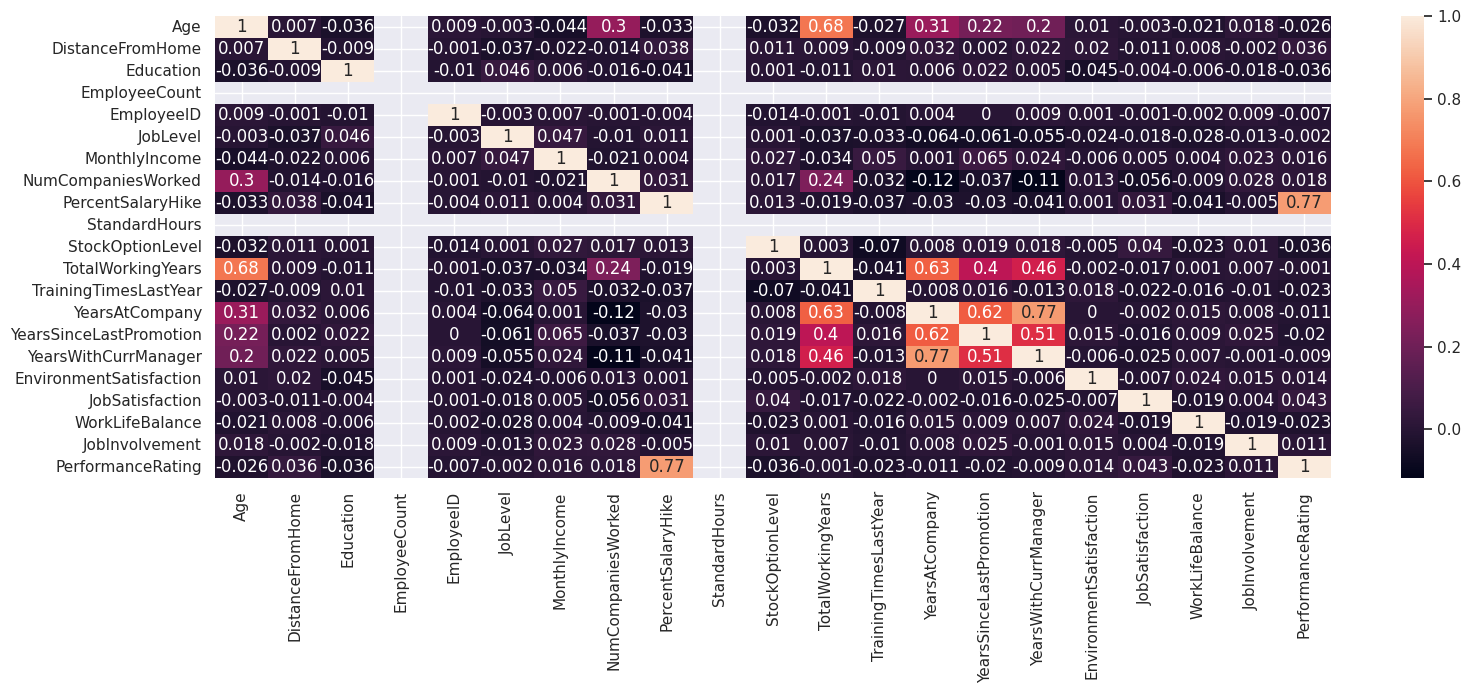

In [ ]:
corr = general_data.corr().round(3)
sns.heatmap(corr, annot=True)

Определение пропусков:

* NumCompaniesWorked - количество прошлых мест работы, заполню средним
* TotalWorkingYears - стаж работы, заполню средним
* EnvironmentSatisfaction - уровень удовлетворенности рабочей средой, взять моду
* JobSatisfaction - уровень вовлеченности в работу, взять моду
* WorkLifeBalance - work life balance level, взять моду

Заполнение пропусков

In [ ]:
general_data.columns[general_data.isna().any()].tolist()

['NumCompaniesWorked',
 'TotalWorkingYears',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance']

In [ ]:
general_data.NumCompaniesWorked = general_data.NumCompaniesWorked.fillna(general_data.NumCompaniesWorked.mean())
general_data.TotalWorkingYears = general_data.TotalWorkingYears.fillna(general_data.TotalWorkingYears.mean())

general_data.EnvironmentSatisfaction = general_data.EnvironmentSatisfaction.fillna(general_data.EnvironmentSatisfaction.mode()[0])
general_data.JobSatisfaction = general_data.JobSatisfaction.fillna(general_data.JobSatisfaction.mode()[0])
general_data.WorkLifeBalance = general_data.WorkLifeBalance.fillna(general_data.WorkLifeBalance.mode()[0])

In [ ]:
general_data.columns[general_data.isna().any()].tolist()

[]

Кодировка переменных:

 * Attrition - LabelEncoder
 * BusinessTravel - One-Hot Encoding
 * Department - OH
 * EducationField - OH
 * Gender - LE
 * JobRole - OH
 * MaritalStatus - OH
 * Over18 - LE

In [ ]:
#One-Hot
general_data = general_data.assign(**pd.get_dummies(general_data.BusinessTravel))
general_data = general_data.assign(**pd.get_dummies(general_data.Department))
general_data = general_data.assign(**pd.get_dummies(general_data.EducationField))
general_data = general_data.assign(**pd.get_dummies(general_data.JobRole))
general_data = general_data.assign(**pd.get_dummies(general_data.MaritalStatus))
#LabelEncoder
general_data.Attrition = general_data.Attrition.astype('category').cat.codes
general_data.Gender = general_data.Gender.astype('category').cat.codes
general_data.Over18 = general_data.Over18.astype('category').cat.codes

Обучение модели линейной регресии

In [ ]:
x = general_data.drop(columns=['EmployeeID', 'Attrition', 'BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus'])
y = general_data['Attrition']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [ ]:
LR_model = LogisticRegression(max_iter=10000).fit(x_train, y_train)
print('Train', accuracy_score(LR_model.predict(x_train), y_train))
print('Test', accuracy_score(LR_model.predict(x_test), y_test))

Train 0.8432539682539683
Test 0.8208616780045351


Изучим коэффициенты LR. Определяем, какие параметры имеют наибольший и наименьший вес.

In [ ]:
coef_name = pd.DataFrame(LR_model.coef_, columns=x.columns).T
coef_name

,0
Age,-3.179501e-02
DistanceFromHome,-6.901266e-03
Education,-2.106019e-03
EmployeeCount,-7.047545e-04
Gender,-3.782586e-04
JobLevel,-1.456272e-03
MonthlyIncome,-8.621883e-07
NumCompaniesWorked,-1.717532e-03
Over18,0.000000e+00
PercentSalaryHike,-1.022680e-02
